# Year by year comparison

(2016 vs 2017 vs 2018 vs 2019 vs 2020 vs 2021)

Is there consistency? e.g. thrombolysis, arrival to scan, ambulance times. Note: we don't know if they had COVID.

Existing research includes:
* https://www.strokeaudit.org/SupportFiles/Documents/Webinars/Webinar-slides.aspx
* https://www.strokeaudit.org/SupportFiles/Documents/Research/Impact-of-Covid-on-SU-access-Poster-Number-098.aspx
* https://www.ahajournals.org/doi/pdf/10.1161/STROKEAHA.120.032253 (and they have COVID-19 status for 23%)

Aim is to understand whether it would be appropriate to include 2016 or 2020 or 2021 in analysis.

## Set up

In [1]:
# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import os
import pandas as pd

# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    restrict_filename = 'reformatted_data_restricted.csv'
    notebook = '01'


paths = Paths()

## Load and restrict data

Need to inspect patterns of admissions and thrombolysis patients to determine an appropriate restriction.

In [2]:
# Load data
raw_data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))

In [114]:
# Loop through name (each stroke team) and group_df (relevant rows from data)
# Identify if meet conditions and save to appropriate list
discard = []
groups = raw_data.groupby('stroke_team')
for name, group_df in groups:
    # Find admissions and thrombolysis use per year
    test_restrictions = pd.concat(
        [group_df.groupby('year').size().rename('admissions'),
         group_df.groupby('year')['thrombolysis'].sum()],
        axis=1).reset_index()
    test_restrictions['stroke_team'] = name
    # Check if any fail conditions
    if ((any(test_restrictions['admissions'] < 100)) or
        (any(test_restrictions['thrombolysis'] < 3))):
        discard.append(test_restrictions)

# Concatenate output and see if discarded teams changes
admissions_thrombolysis = pd.concat(discard)

14:9: E129 visually indented line with same indent as next logical line


In [124]:
admissions_thrombolysis

,year,admissions,thrombolysis,stroke_team
0,2016,110,24,Bronglais Hospital
1,2017,96,18,Bronglais Hospital
2,2018,107,28,Bronglais Hospital
3,2019,91,21,Bronglais Hospital
4,2020,94,21,Bronglais Hospital
5,2021,87,24,Bronglais Hospital
0,2020,77,3,Grange University Hospital
1,2021,416,51,Grange University Hospital
0,2016,916,100,Leeds General Infirmary
1,2017,750,73,Leeds General Infirmary


Things to consider:
* Warwick hospital consistently has around 150 admissions but always less than 10 thrombolysis patients per year,  sometimes 0
* Some hospitals appear to close (e.g. William Harvey) - so would drop some years but not the whole hospital
* In 2018, Leeds had 23 admissions and 7 thrombolysis patients

Possible solution:
* Drop years where admissions are very low
* Do not drop on the basis of thrombolysis numbers (unless we do want to if those are not likely to actually be stroke units?)

Suggestion of 30, which is a common number for aggregation, and may be appropriate (eg. if Leeds 2018 23 admissions is a slightly anonamlous result).

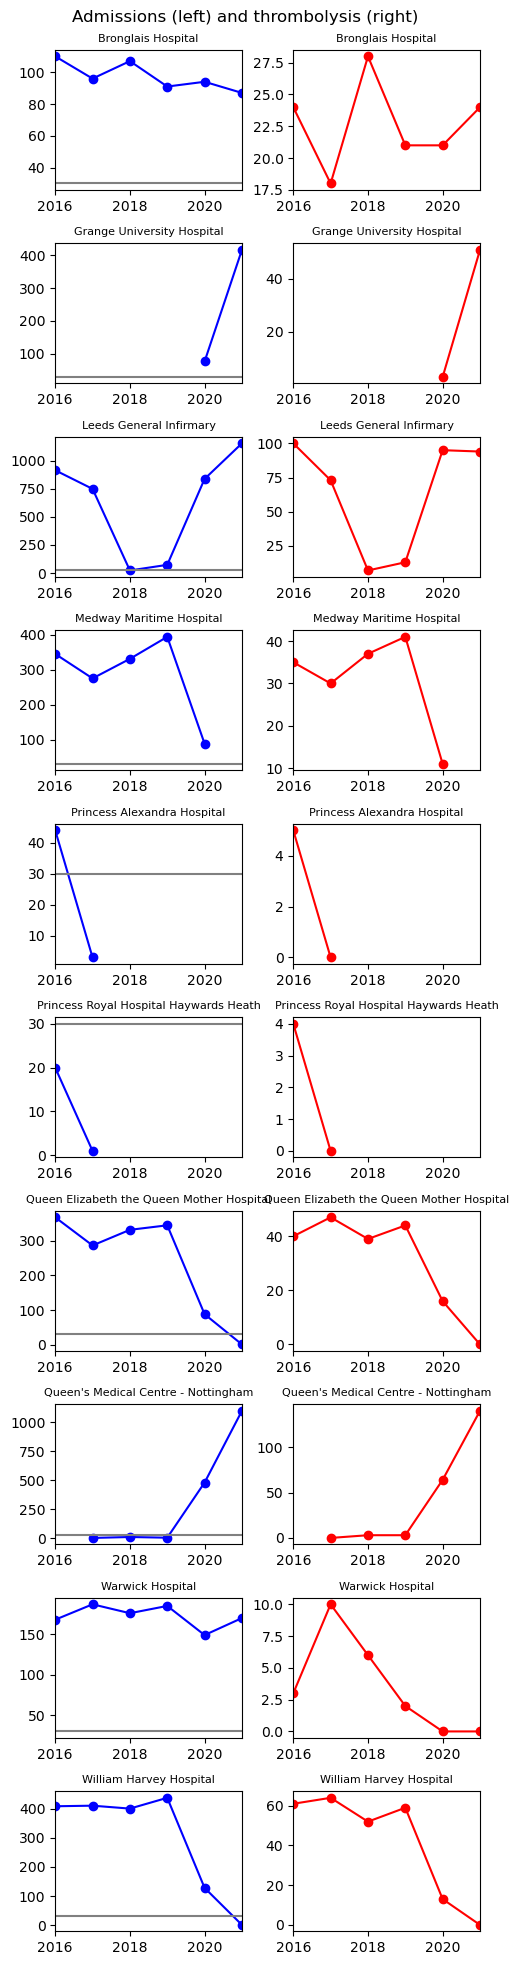

In [125]:
# Group by stroke team and loop through
admissions_thrombolysis_teams = admissions_thrombolysis.groupby('stroke_team')

# Set up figure and counter
fig, ax = plt.subplots(figsize=(5, 20),
                       nrows=len(admissions_thrombolysis_teams), ncols=2)
i = 0

# Loop through teams and plot
for name, group_df in admissions_thrombolysis_teams:
    # Admissions plot
    group_df.plot(x='year', y='admissions', linestyle='-', marker='o',
                  ax=ax[i, 0], color='blue', legend=False, xlabel='')
    ax[i, 0].hlines(y=30, xmin=2016, xmax=2021, color='grey')
    plt.setp(ax[i, 0], xlim=[2016, 2021])
    ax[i, 0].set_title(name, fontsize=8)

    # Thrombolysis patients plot
    group_df.plot(x='year', y='thrombolysis', linestyle='-', marker='o',
                  ax=ax[i, 1], color='red', legend=False, xlabel='')
    plt.setp(ax[i, 1], xlim=[2016, 2021])
    ax[i, 1].set_title(name, fontsize=8)

    i += 1

fig.tight_layout()
fig.suptitle('Admissions (left) and thrombolysis (right)')
fig.subplots_adjust(top=0.96)
plt.show()